# SWE Reanalysis EOF and K-Means Clustering

In [4]:
import numpy as np
import os
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import contextily as ctx
import ulmo
import datetime as dt
from datetime import datetime
from shapely.geometry import Point
import metloom
from metloom.pointdata import CDECPointData
from metloom.pointdata import SnotelPointData
from metloom.variables import CdecStationVariables
import pickle
import scipy.stats as stats
# SVD function from scipy
from scipy.linalg import svd
import sklearn
from sklearn.cluster import KMeans

import rioxarray as rxr
import xarray as xr

In [56]:
wstates = gpd.read_file('../data/misc/western_states.shp')
wstates_4326=wstates.to_crs('epsg:4326')

wstates_boundary = gpd.read_file('../data/misc/western_boundary.geojson')

station_locations_co = pickle.load(open('../data/station_locations_co.pkl', 'rb'))
combined_april1_anom_co = pickle.load(open('../data/combined_april1_anom_co.pkl', 'rb'))

In [5]:
base_dir = '../data/reanalysis/' 
fname_lst = []
## create list of netcdf files ##
years = list(sorted((f for f in os.listdir(base_dir) if not f.startswith(".")), key=str.lower))
for year in years:
    yr_dir = f'{base_dir}{year}/'
    fname = os.listdir(yr_dir)[0]
    fname_lst.append(f'{base_dir}{year}/{fname}')
## load netcdf ##
def preprocess(ds):
    ds['SD_Post'] = ds['SD_Post'].T
    ## set spatial reference ##
    ds.rio.write_crs('EPSG:4326',inplace = True)
    ds = ds.rename({'Latitude':'y','Longitude':'x'})
    ds = ds.rio.set_spatial_dims('y','x',inplace=True)
    return ds
    # ds.expand_dims(dim = 'Year')
    
## load files and concatenate by Year ##
ds = xr.open_mfdataset(fname_lst, concat_dim = 'Year',combine = 'nested', preprocess = preprocess)
## rename years ##
ds['Year'] = np.arange(1990,2022)
ds

<xarray.Dataset>
Dimensions:      (y: 4050, x: 5175, Year: 32)
Coordinates:
  * y            (y) float64 31.0 31.01 31.01 31.02 ... 48.98 48.99 48.99 49.0
  * x            (x) float64 -125.0 -125.0 -125.0 ... -102.0 -102.0 -102.0
    spatial_ref  int64 0
  * Year         (Year) int64 1990 1991 1992 1993 1994 ... 2018 2019 2020 2021
Data variables:
    SD_Post      (Year, y, x) float32 dask.array<chunksize=(1, 4050, 5175), meta=np.ndarray>

In [6]:
anomalies = ds.SD_Post - ds.SD_Post.mean(dim='Year')

In [7]:
anomalies_sdev = anomalies / ds.SD_Post.std(dim='Year')

In [8]:
anomalies

<xarray.DataArray 'SD_Post' (Year: 32, y: 4050, x: 5175)>
dask.array<sub, shape=(32, 4050, 5175), dtype=float32, chunksize=(1, 4050, 5175), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 31.0 31.01 31.01 31.02 ... 48.98 48.99 48.99 49.0
  * x            (x) float64 -125.0 -125.0 -125.0 ... -102.0 -102.0 -102.0
    spatial_ref  int64 0
  * Year         (Year) int64 1990 1991 1992 1993 1994 ... 2018 2019 2020 2021

In [9]:
anomalies_sdev

<xarray.DataArray 'SD_Post' (Year: 32, y: 4050, x: 5175)>
dask.array<truediv, shape=(32, 4050, 5175), dtype=float32, chunksize=(1, 4050, 5175), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 31.0 31.01 31.01 31.02 ... 48.98 48.99 48.99 49.0
  * x            (x) float64 -125.0 -125.0 -125.0 ... -102.0 -102.0 -102.0
    spatial_ref  int64 0
  * Year         (Year) int64 1990 1991 1992 1993 1994 ... 2018 2019 2020 2021

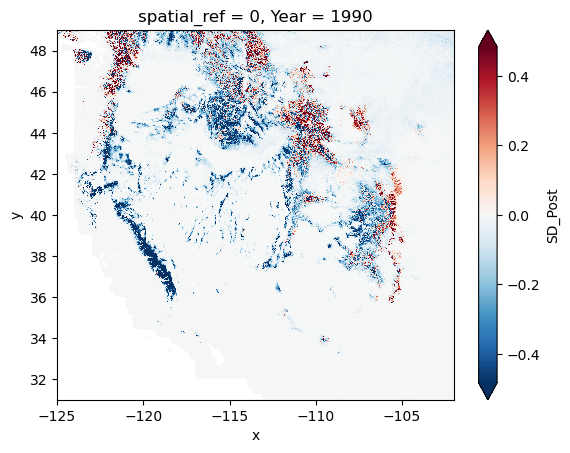

In [10]:
anomalies[0].plot(robust=True)

/Users/Hannah/micromamba/envs/analysis_2023/lib/python3.9/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/Users/Hannah/micromamba/envs/analysis_2023/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


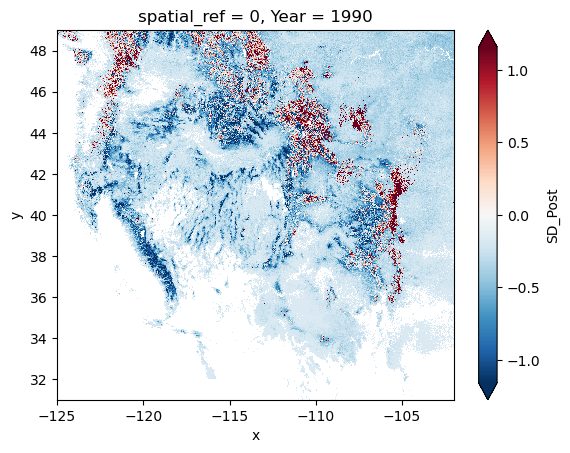

In [11]:
anomalies_sdev[0].plot(robust=True) 

Because of the issue with dividing by 0, I will start by just using the anomalies, instead of the anomaly divided by standard deviation.

In [12]:
anomalies.rio.crs

CRS.from_epsg(4326)

In [13]:
min_lon = -109.060253
min_lat = 36.992426
max_lon = -102.041524
max_lat = 41.003444

subset = anomalies.rio.clip_box(minx=min_lon, miny=min_lat, maxx=max_lon, maxy=max_lat)

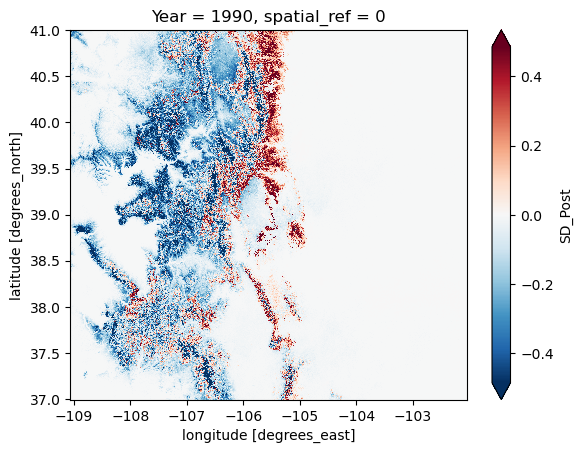

In [14]:
subset[0].plot(robust=True)

In [141]:
subset

<xarray.DataArray 'SD_Post' (Year: 32, y: 903, x: 1580)>
dask.array<getitem, shape=(32, 903, 1580), dtype=float32, chunksize=(1, 903, 1580), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 36.99 37.0 37.0 37.01 ... 40.99 40.99 41.0 41.0
  * x            (x) float64 -109.1 -109.1 -109.1 ... -102.1 -102.0 -102.0
  * Year         (Year) int64 1990 1991 1992 1993 1994 ... 2018 2019 2020 2021
    spatial_ref  int64 0

In [15]:
flattened_subset = subset.stack(z=('x','y'))
flattened_subset

<xarray.DataArray 'SD_Post' (Year: 32, z: 1426740)>
dask.array<reshape, shape=(32, 1426740), dtype=float32, chunksize=(1, 1426740), chunktype=numpy.ndarray>
Coordinates:
  * Year         (Year) int64 1990 1991 1992 1993 1994 ... 2018 2019 2020 2021
    spatial_ref  int64 0
  * z            (z) object MultiIndex
  * x            (z) float64 -109.1 -109.1 -109.1 ... -102.0 -102.0 -102.0
  * y            (z) float64 36.99 37.0 37.0 37.01 ... 40.99 40.99 41.0 41.0

In [16]:
flattened_anomalies = anomalies.stack(z=('x','y'))

In [17]:
# Perform the SVD

# perform svd analysis on swe reanalysis data
Ur, Sr, Vr = svd(flattened_subset.T,full_matrices=False)

In [58]:
# for comparison
combined_april1_anom_co_array = combined_april1_anom_co.to_numpy()

In [59]:
Uco, Sco, Vco = svd(combined_april1_anom_co_array.T,full_matrices=False)

In [20]:
# SVD Variance Explained, divide S values by the sum of all S
var_exp = Sr / np.sum(Sr)

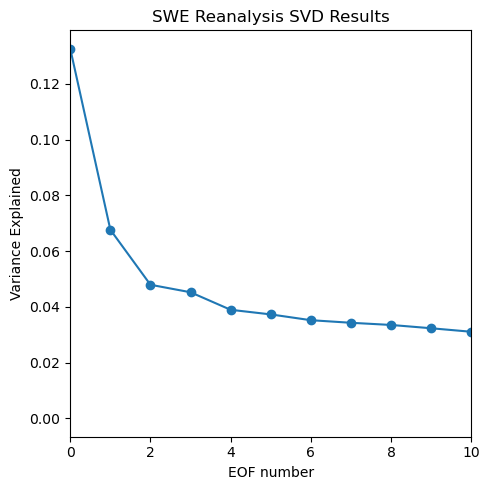

In [28]:
plt.figure(figsize=(5,5))
plt.plot(var_exp,'-o')
plt.xlabel('EOF number')
plt.ylabel('Variance Explained')
#plt.title('SVD Variance Explained')
#plt.ylim([0,0.16])
plt.xlim([0,10])
plt.title('SWE Reanalysis SVD Results')
plt.tight_layout()
plt.savefig('../figures/91823/reanalysis_eof_varianceexplained.jpeg');

In [29]:
# the first 10:
#print(var_exp[0:10])

# sum of the first 10
print('Percent of overall variance explained by \nthe top 10 patterns = {}%'.format( np.round( 100*np.sum(var_exp[0:10]),1)), '\nthe top 4 patterns = {}%'.format( np.round( 100*np.sum(var_exp[0:4]),1)))

Percent of overall variance explained by 
the top 10 patterns = 50.5% 
the top 4 patterns = 29.3%


In [23]:
# the first 10:
print(var_exp[0:4])

# sum of the first 10
print('Percent of overall variance expplained by the top 4 patterns = {}%'.format( np.round( 100*np.sum(var_exp[0:4]),1)))

[0.13256538 0.06763978 0.04789902 0.04521023]
Percent of overall variance expplained by the top 4 patterns = 29.3%


In [18]:
Ur.shape

(1426740, 32)

In [19]:
Ur_t = Ur.T
Ur_t.shape

(32, 1426740)

In [25]:
subset.shape

(32, 903, 1580)

In [26]:
# dims: [time, y, x] 

Ur_t_reshaped = Ur_t.reshape(
        subset.shape[0], subset.shape[1], subset.shape[2]
    )

In [31]:
np.linspace(1, 32, num=32, dtype=int)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32])

In [32]:
Ur_t_reshaped = Ur_t.reshape(
        subset.shape[0], subset.shape[2], subset.shape[1]
    )

Ur_dataArray = xr.DataArray(data = Ur_t_reshaped,
                           dims=("EOF","x","y"),
                           coords=[np.linspace(1, 32, num=32, dtype=int),subset.x,subset.y])

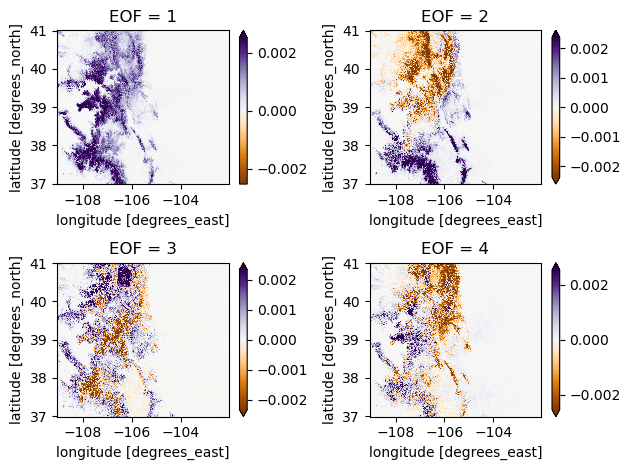

In [65]:
f, ax = plt.subplots(2,2)
i = 0
for row in range(2):
    for column in range(2):
        Ur_dataArray[i].T.plot(ax=ax[row,column], robust=True, cmap='PuOr')
        i+=1
plt.tight_layout()
plt.savefig('../figures/91823/reanalysis_eof_plots.jpeg')

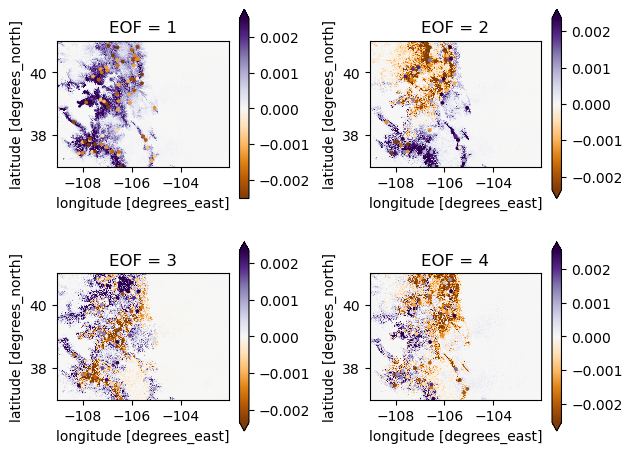

In [63]:
f, ax = plt.subplots(2,2)
i = 0
for row in range(2):
    for column in range(2):
        Ur_dataArray[i].T.plot(ax=ax[row,column], robust=True, cmap='PuOr')
        station_locations_co.plot(ax=ax[row,column], column=Uco[:,i], legend=False, cmap='PuOr', vmin=-0.16, vmax=0.16, markersize=3,marker='o')

        # ax[row,column].set_xlim(-109.2,-102.5)
        # ax[row,column].set_ylim(36.7,41.2)
        # ctx.add_basemap(ax=ax[row,column], crs='epsg:4326', source=ctx.providers.Stamen.Terrain, attribution=False)
        # colorado.plot(ax=ax[row,column], facecolor='none', edgecolor='k')
        # ax[row,column].set_title('EOF {}'.format(i+1))
        # ax[row,column].set_xlabel('Longitude')
        # ax[row,column].set_ylabel('Latitude')
        i+=1
plt.tight_layout()
#plt.savefig('../figures/91823/station_eof_plots.jpeg')

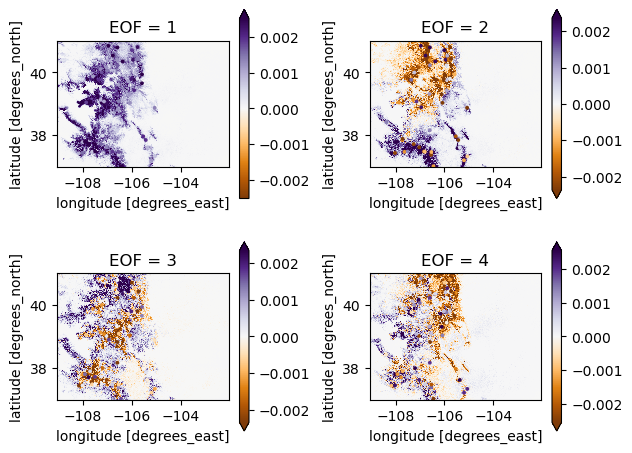

In [64]:
f, ax = plt.subplots(2,2)
i = 0
for row in range(2):
    for column in range(2):
        Ur_dataArray[i].T.plot(ax=ax[row,column], robust=True, cmap='PuOr')
        station_locations_co.plot(ax=ax[row,column], column=Uco[:,i], legend=False, cmap='PuOr_r', vmin=-0.16, vmax=0.16, markersize=3,marker='o')

        # ax[row,column].set_xlim(-109.2,-102.5)
        # ax[row,column].set_ylim(36.7,41.2)
        # ctx.add_basemap(ax=ax[row,column], crs='epsg:4326', source=ctx.providers.Stamen.Terrain, attribution=False)
        # colorado.plot(ax=ax[row,column], facecolor='none', edgecolor='k')
        # ax[row,column].set_title('EOF {}'.format(i+1))
        # ax[row,column].set_xlabel('Longitude')
        # ax[row,column].set_ylabel('Latitude')
        i+=1
plt.tight_layout()
#plt.savefig('../figures/91823/station_eof_plots.jpeg')

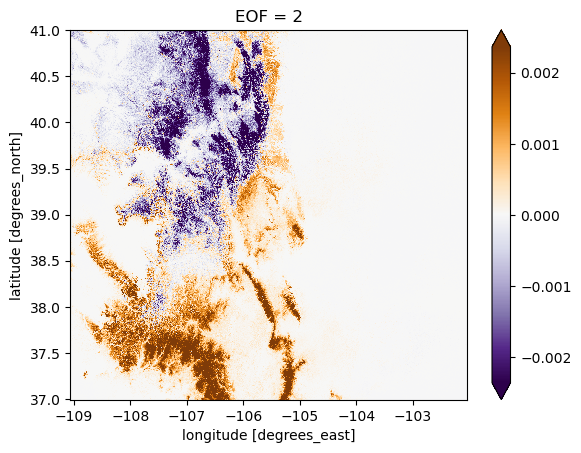

In [36]:
Ur_dataArray[1].T.plot(robust=True, cmap='PuOr_r')

In [90]:
# Perform the SVD

# perform svd analysis on swe reanalysis data
Ura, Sra, Vra = svd(flattened_anomalies.T,full_matrices=False)

type: array must not contain infs or NaNs

Need to deal with nan values inherent to nonrectangular data